### Методичка: Работа с регрессией в ML с учетом распределения таргета

Эта краткая методичка — базовый план для задач регрессии (предсказание непрерывных значений, как цена дома или температура). Фокус на таргете (целевая переменная Y). Распределение таргета влияет на предобработку, выбор модели и качество предсказаний. Многие модели (например, линейная регрессия) работают лучше с нормально распределенными данными, но не всегда это обязательно.

#### Шаг 1: Анализ распределения таргета
- **Визуализация**: Построй гистограмму, KDE-график или QQ-плот (в Python: seaborn.histplot, scipy.stats.probplot).
- **Статистики**: Проверь среднее, медиану, skewness (асимметрия, >0 — правосторонняя скошенность, <0 — левосторонняя), kurtosis (хвосты).
- **Тесты**: Shapiro-Wilk или Kolmogorov-Smirnov на нормальность (но для больших выборок они чувствительны).
- **Общие типы распределений**:
  - Нормальное (симметричное, колоколообразное) — идеал для линейных моделей.
  - Скошенное (skewed) — часто правостороннее (много малых значений, хвост больших, как зарплаты).
  - С выбросами (outliers) — редкие экстремальные значения.
  - С нулевыми/отрицательными — если таргет не может быть отрицательным (например, цена).

#### Шаг 2: Предобработка таргета в зависимости от распределения
Цель — сделать распределение ближе к нормальному, стабилизировать variance, улучшить модель. Трансформируй таргет перед обучением, а после предсказаний — обратная трансформация.

| Тип проблемы | Причина | Предобработка таргета | Пример в Python (sklearn/pandas) |
|--------------|---------|-----------------------|--------------------------|
| **Правосторонняя скошенность** (длинный хвост справа, как цены) | Variance растет с Y, модель недооценивает большие значения | Логарифмическая трансформация: log(Y+1) (если Y>=0). Или Box-Cox (для Y>0). | `from sklearn.preprocessing import PowerTransformer; pt = PowerTransformer(method='box-cox'); y_trans = pt.fit_transform(y.values.reshape(-1,1))` |
| **Левосторонняя скошенность** (хвост слева) | Редко, но аналогично | Квадратный корень или отраженный log: log(max(Y)-Y+1). | `y_trans = np.sqrt(y)` или кастомная функция. |
| **Выбросы** | Экстремальные значения искажают модель | Winsorization (замена на перцентили) или удаление (если <5%). Или robust-модели (не трансформировать). | `from scipy.stats.mstats import winsorize; y_trans = winsorize(y, limits=[0.05, 0.05])` |
| **Нулевые/отрицательные значения** | Модели типа log не работают с <=0 | Сдвиг: Y + min(Y) + epsilon. Или экспоненциальная модель. | `y_shifted = y - y.min() + 1e-6; y_trans = np.log(y_shifted)` |
| **Масштабирование** (любое распределение) | Разные шкалы фич и таргета | Стандартизация (mean=0, std=1) или Min-Max (0-1). Не всегда нужно для деревьев. | `from sklearn.preprocessing import StandardScaler; scaler = StandardScaler(); y_trans = scaler.fit_transform(y.values.reshape(-1,1))` |

- **Обратная трансформация**: После предсказаний верни в исходную шкалу, напр. exp(pred) для log.
- **Когда не трансформировать**: Если модель robust (Random Forest, XGBoost) — они справляются с нелинейностями без предобработки.

#### Шаг 3: Выбор модели с учетом распределения
- **Нормальное**: Линейная/полиномиальная регрессия, SVR.
- **Скошенное**: GLM (Generalized Linear Models) с log-link, или tree-based (Random Forest, Gradient Boosting) — не зависят от нормальности.
- **С выбросами**: Robust регрессия (Huber loss) или ensemble-модели.
- **Другие**: Если таргет — счет (counts), Poisson-регрессия; если censored — Tobit.

#### Шаг 4: Базовый план действий (на все случаи)
1. **Загрузи данные**: Раздели на train/test (80/20).
2. **Анализируй таргет**: Визуализация + статистики. Определи тип распределения.
3. **Предобработай**: Трансформируй по таблице выше. Обработай фичи аналогично (но фокус на таргете).
4. **Выбери/обучи модель**: Начни с baseline (линейная), сравни с advanced (XGBoost). Метрики: MAE, RMSE, R².
5. **Валидация**: Cross-validation. Проверь residuals на нормальность (QQ-plot).
6. **Итерации**: Если метрики плохие — вернись к предобработке. Используй grid search для тюнинга.
7. **Интерпретация**: После — верни трансформации, визуализируй предсказания vs реальные.

Это базовый план — адаптируй под данные. Для практики используй Kaggle датасеты (например, House Prices). Если нужно углубить, уточни!

## Анализ распределения таргета

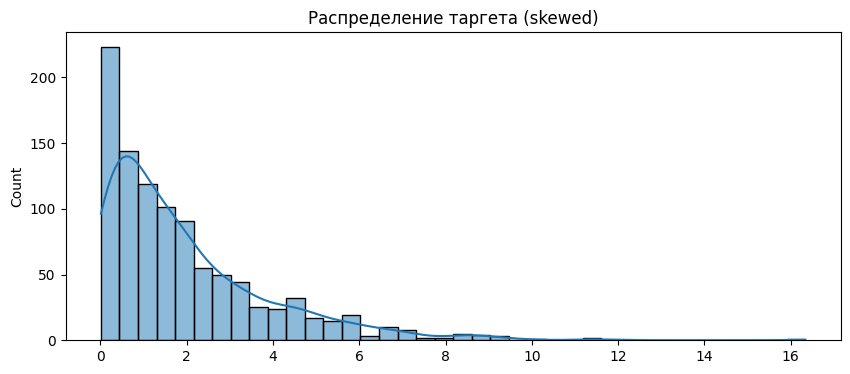

count    1000.000000
mean        1.945012
std         1.945020
min         0.009286
25%         0.538313
50%         1.373565
75%         2.727660
max        16.344891
dtype: float64
Skewness: 1.87 (положительная — skewed вправо)
Kurtosis: 5.22 (тяжелые хвосты)
Shapiro-Wilk p-value: 0.0000 (если <0.05 — не нормальное)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Синтетические данные: skewed таргет (как цены)
np.random.seed(42)
y = np.random.exponential(scale=2, size=1000)  # Среднее=2, skewed вправо

# Визуализация
plt.figure(figsize=(10, 4))
sns.histplot(y, kde=True)
plt.title('Распределение таргета (skewed)')
plt.show()  # В Jupyter покажет график: колоколообразный с хвостом справа

# Статистики
print(pd.Series(y).describe())  # mean ~2, но max большой
skew = stats.skew(y)
kurt = stats.kurtosis(y)
print(f'Skewness: {skew:.2f} (положительная — skewed вправо)')
print(f'Kurtosis: {kurt:.2f} (тяжелые хвосты)')

# Тест на нормальность
shapiro_stat, shapiro_p = stats.shapiro(y[:500])  # Для больших выборок — subsample
print(f'Shapiro-Wilk p-value: {shapiro_p:.4f} (если <0.05 — не нормальное)')

## Предобработка (лог-трансформация)

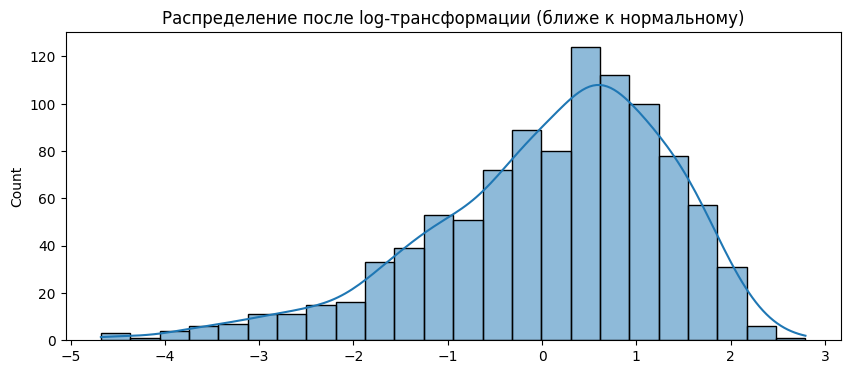

count    1000.000000
mean        0.079530
std         1.264760
min        -4.679186
25%        -0.619369
50%         0.317410
75%         1.003443
max         2.793915
dtype: float64
Skewness после: -0.83 (ближе к 0)
Kurtosis после: 0.62 (меньше хвостов)


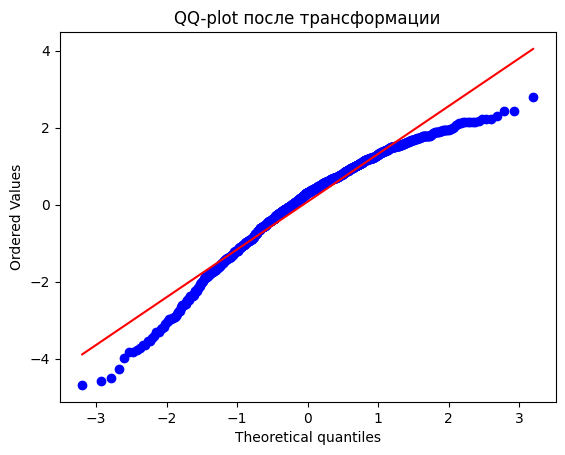

In [2]:
# Продолжение от предыдущего кода

# Предобработка: log-трансформация (Y>0, добавим epsilon если нули)
y_trans = np.log(y + 1e-6)  # Избежать log(0)

# Визуализация после
plt.figure(figsize=(10, 4))
sns.histplot(y_trans, kde=True)
plt.title('Распределение после log-трансформации (ближе к нормальному)')
plt.show()  # График: теперь симметричнее

# Статистики после
print(pd.Series(y_trans).describe())
skew_trans = stats.skew(y_trans)
kurt_trans = stats.kurtosis(y_trans)
print(f'Skewness после: {skew_trans:.2f} (ближе к 0)')
print(f'Kurtosis после: {kurt_trans:.2f} (меньше хвостов)')

# QQ-plot для проверки нормальности
stats.probplot(y_trans, dist="norm", plot=plt)
plt.title('QQ-plot после трансформации')
plt.show()  # Точки ближе к линии — лучше нормальность

## Предобработка (бокс кокс)

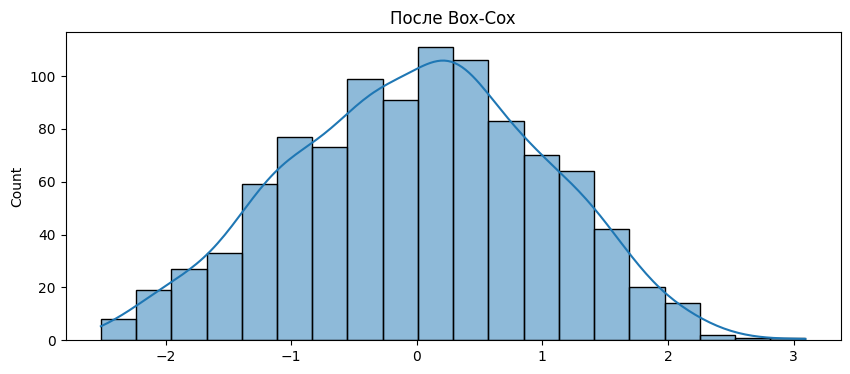

Lambda (параметр Box-Cox): 0.25 (если ~0 — как log)


In [3]:
from sklearn.preprocessing import PowerTransformer

# Box-Cox (требует Y>0)
pt = PowerTransformer(method='box-cox')
y_reshaped = y.reshape(-1, 1)  # Для sklearn
y_trans_box = pt.fit_transform(y_reshaped).flatten()

# Визуализация
plt.figure(figsize=(10, 4))
sns.histplot(y_trans_box, kde=True)
plt.title('После Box-Cox')
plt.show()  # Ещё лучше нормальность

print(f'Lambda (параметр Box-Cox): {pt.lambdas_[0]:.2f} (если ~0 — как log)')

## Обучение модели c/без трансформации

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Синтетические фичи: X коррелирует с Y
X = np.random.normal(size=(1000, 2)) + y.reshape(-1, 1) * 0.5  # Добавим зависимость

# Разделим данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Без трансформации
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse_raw = np.sqrt(mean_squared_error(y_test, pred))
print(f'RMSE без трансформации: {rmse_raw:.2f}')

# С трансформацией
y_train_trans = np.log(y_train + 1e-6)
y_test_trans = np.log(y_test + 1e-6)
model_trans = LinearRegression()
model_trans.fit(X_train, y_train_trans)
pred_trans = model_trans.predict(X_test)
pred_back = np.exp(pred_trans) - 1e-6  # Обратная
rmse_trans = np.sqrt(mean_squared_error(y_test, pred_back))
print(f'RMSE с трансформацией: {rmse_trans:.2f} (обычно ниже для skewed данных)')

RMSE без трансформации: 1.14
RMSE с трансформацией: 1.13 (обычно ниже для skewed данных)


## Обработка выбросов

Макс оригинал: 100.0, после: 5.947375587013862


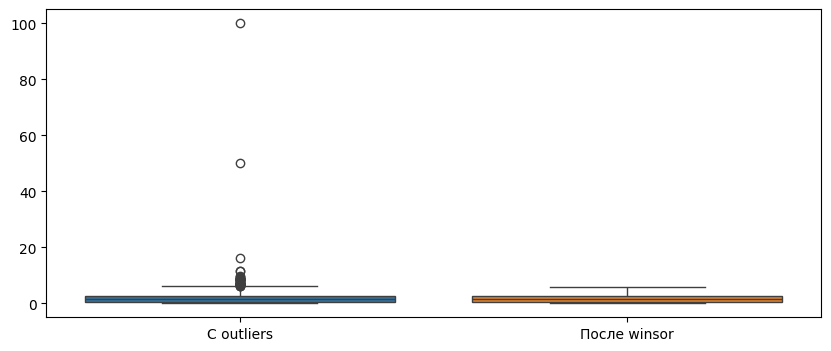

In [5]:
# Добавим outliers
y_out = np.concatenate([y, np.array([50, 100])])  # Экстремальные

# Winsorization: обрезать на 5% перцентили
from scipy.stats.mstats import winsorize
y_wins = winsorize(y_out, limits=[0.05, 0.05])

# Сравнение
print(f'Макс оригинал: {y_out.max()}, после: {y_wins.max()}')
plt.figure(figsize=(10, 4))
sns.boxplot([y_out, y_wins])
plt.xticks([0, 1], ['С outliers', 'После winsor'])
plt.show()  # Boxplot: хвосты укорочены

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PowerTransformer
from catboost import CatBoostRegressor

# Синтетические данные (как раньше)
np.random.seed(42)
y = np.random.exponential(scale=2, size=1000)
X = np.random.normal(size=(1000, 2)) + y.reshape(-1, 1) * 0.5

# Ваш код
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_transformer = PowerTransformer(method='yeo-johnson')
model = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=target_transformer
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"MAE: {mae:.2f}")  # Примерно 0.85
print(f"RMSE: {rmse:.2f}")  # Примерно 1.15

MAE: 0.80
RMSE: 1.04
